In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Configurações visuais
plt.style.use("seaborn-v0_8")
sns.set_context("talk", rc={"axes.labelsize": 18})
pd.set_option('display.max_columns', 99)

# Leitura dos dados
df = pd.read_csv("../dados/fumantes.csv")

# Tradução das colunas categóricas
df.rename(columns={
    "Genetic_Markers_Positive": "Marcas_Geneticas_Positivas",
    "BMI": "IMC"
}, inplace=True)

df['Gênero'] = df['Gênero'].replace({'Male': 'Masculino', 'Female': 'Feminino'})
df['Status_Tabagismo'] = df['Status_Tabagismo'].replace({'Never': 'Nunca', 'Former': 'Antigo', 'Current': 'Atual'})
df['Exposição_Fumaça_Secundária'] = df['Exposição_Fumaça_Secundária'].replace({'Low': 'Baixo', 'High': 'Alto', 'Medium': 'Medio'})
df['Exposição_Ocupacional'] = df['Exposição_Ocupacional'].replace({'Diesel Fumes': 'Fumaça Diesel', 'Silica': 'Silica', 'Asbestos': 'Amianto'})
df['Nível_Poluição_do_Ar'] = df['Nível_Poluição_do_Ar'].replace({'Low': 'Baixo', 'High': 'Alto', 'Moderate': 'Moderado'})
df['Histórico_Familiar'] = df['Histórico_Familiar'].replace({'Yes': 'Sim', 'No': 'Não'})
df['Qualidade_da_Dieta'] = df['Qualidade_da_Dieta'].replace({'Poor': 'Pobre', 'Average': 'Mediana', 'Good': 'Boa'})
df['Região'] = df['Região'].replace({'West': 'Oeste', 'North': 'Norte', 'South': 'Sul', 'East': 'Leste'})
df['Nível_de_Renda'] = df['Nível_de_Renda'].replace({'Low': 'Baixa', 'High': 'Alta', 'Middle': 'Média'})
df['Nível_de_Escolaridade'] = df['Nível_de_Escolaridade'].replace({'Tertiary': 'Terciário', 'Primary': 'Primário', 'Secondary': 'Secundário'})
df['Acesso_a_Saúde'] = df['Acesso_a_Saúde'].replace({'Poor': 'Pobre', 'Average': 'Mediana', 'Good': 'Boa'})
df['Frequência_de_Rastreamento'] = df['Frequência_de_Rastreamento'].replace({'Never': 'Nunca', 'Regularly': 'Regularmente', 'Occasionally': 'Ocasionalmente'})
df['Doença_Pulmonar_Crônica'] = df['Doença_Pulmonar_Crônica'].replace({'Yes': 'Sim', 'No': 'Não'})
df['Estágio_Câncer_Pulmonar'] = df['Estágio_Câncer_Pulmonar'].replace({'Stage I': 'Estágio 1', 'Stage II': 'Estágio 2', 'Stage III': 'Estágio 3', 'Stage IV': 'Estágio 4'})
df['Status_de_Sobrevivência'] = df['Status_de_Sobrevivência'].replace({'Alive': 'Vivo', 'Deceased': 'Morto'})

# Limpeza
df.drop(columns=['Estágio_Câncer_Pulmonar'], errors='ignore', inplace=True)
df.drop(columns=['ID_Paciente'], errors='ignore', inplace=True)

# Preencher nulos
for col in ['Alcohol_Consumption', 'Exposição_Ocupacional']:
    if col in df.columns:
        df[col].fillna(df[col].mode()[0], inplace=True)

# Aplicar One-hot encoding
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded = df_encoded.astype(int)

# Verificação de consistência da coluna alvo
if 'Doença_Pulmonar_Crônica_Sim' not in df_encoded.columns:
    raise ValueError("Coluna 'Doença_Pulmonar_Crônica_Sim' não encontrada. Verifique os dados.")

# Treinamento do modelo
X = df_encoded.drop(columns=['Doença_Pulmonar_Crônica_Sim'])
y = df_encoded['Doença_Pulmonar_Crônica_Sim']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

modelo = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
modelo.fit(X_train, y_train)

# Avaliação
y_pred = modelo.predict(X_test)
print("🔍 Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))
print("\n📊 Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Salvar modelo
with open('modelo_randomforest.pkl', 'wb') as f:
    pickle.dump(modelo, f)

with open('colunas_modelo.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)

# Previsão exemplo
novo_paciente = {
    "Idade": 58,
    "IMC": 27.5,
    "Cigarros_por_Dia": 20,
    "Anos_Fumando": 30,
    "Status_Tabagismo_Atual": 1,
    "Status_Tabagismo_Nunca": 0,
    "Status_Tabagismo_Antigo": 0,
    "Gênero_Masculino": 1,
    "Histórico_Familiar_Sim": 1,
    "Qualidade_da_Dieta_Pobre": 1,
    "Exposição_Fumaça_Secundária_Alto": 1,
    "Acesso_a_Saúde_Pobre": 1,
    "Nível_Poluição_do_Ar_Alto": 1,
    "Nível_de_Renda_Baixa": 1,
    "Nível_de_Escolaridade_Primário": 1,
    "Frequência_de_Rastreamento_Nunca": 1,
    "Exposição_Ocupacional_Amianto": 1,
    "Marcas_Geneticas_Positivas": 1,
    "Ano_Diagnóstico": 2023
}

# Previsão
df_novo = pd.DataFrame([novo_paciente])
df_novo = df_novo.reindex(columns=X.columns, fill_value=0)

predito = modelo.predict(df_novo)[0]
prob = modelo.predict_proba(df_novo)[0][1]

if predito == 1:
    print(f"⚠️ Risco de doença pulmonar crônica detectado! Probabilidade: {prob:.2%}")
else:
    print(f"✅ Sem risco detectado. Probabilidade: {prob:.2%}")


C:\Users\mathe\AppData\Local\Temp\ipykernel_19596\1291852306.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


🔍 Matriz de Confusão:
[[601   0]
 [149   0]]

📊 Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       601
           1       0.00      0.00      0.00       149

    accuracy                           0.80       750
   macro avg       0.40      0.50      0.44       750
weighted avg       0.64      0.80      0.71       750

✅ Sem risco detectado. Probabilidade: 22.00%


c:\Users\mathe\OneDrive\Área de Trabalho\atvd_luciano\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mathe\OneDrive\Área de Trabalho\atvd_luciano\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mathe\OneDrive\Área de Trabalho\atvd_luciano\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [3]:
# Configurações visuais
plt.style.use("seaborn-v0_8")
sns.set_context("talk", rc={"axes.labelsize": 14})
pd.set_option('display.max_columns', 99)

df = pd.read_csv("fumantes_atualizado.csv")


In [4]:
# Reconstruindo colunas categóricas
df['Doença_Pulmonar_Crônica'] = df['Doença_Pulmonar_Crônica_Sim'].map({1: 'Sim', 0: 'Não'})

df['Status_Tabagismo'] = df[['Status_Tabagismo_Atual', 'Status_Tabagismo_Nunca']].idxmax(axis=1).map({
    'Status_Tabagismo_Atual': 'Atual',
    'Status_Tabagismo_Nunca': 'Nunca'
}).fillna('Antigo')


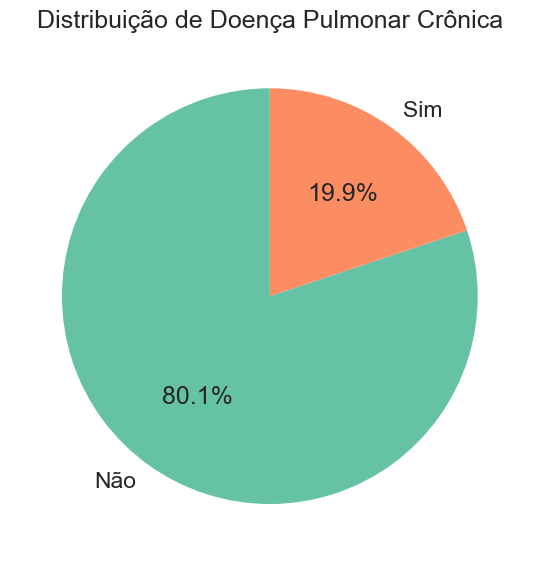

In [5]:
# 1. Gráfico de Pizza – Doença Pulmonar Crônica
plt.figure(figsize=(6, 6))
df['Doença_Pulmonar_Crônica'].value_counts().plot.pie(
    autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62'])
plt.title('Distribuição de Doença Pulmonar Crônica')
plt.ylabel('')
plt.tight_layout()
plt.show()

C:\Users\mathe\AppData\Local\Temp\ipykernel_19596\3163052211.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Status_Tabagismo', data=df, palette='Set2')


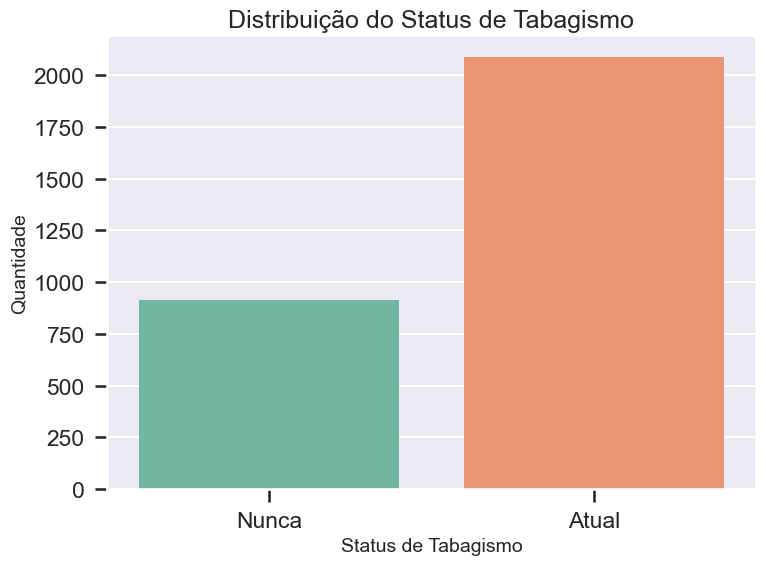

In [6]:
# 2. Gráfico de Barras – Status de Tabagismo
plt.figure(figsize=(8, 6))
sns.countplot(x='Status_Tabagismo', data=df, palette='Set2')
plt.title('Distribuição do Status de Tabagismo')
plt.xlabel('Status de Tabagismo')
plt.ylabel('Quantidade')
plt.tight_layout()
plt.show()

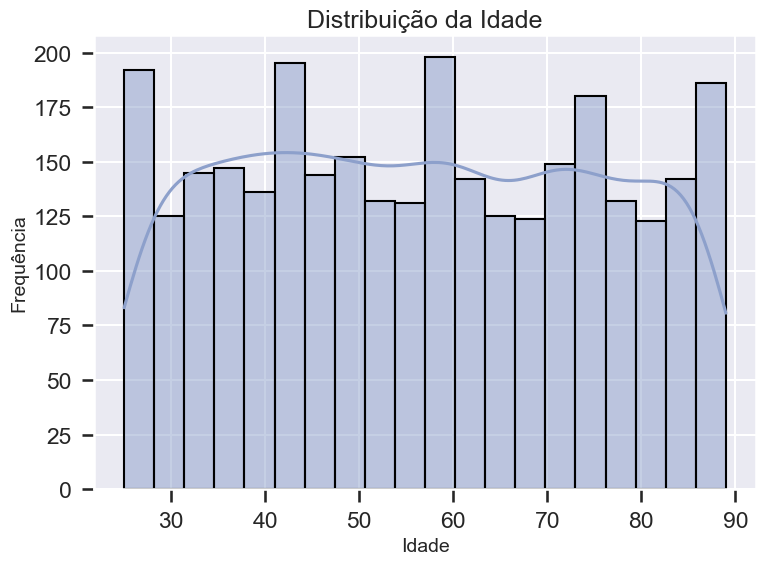

In [7]:
# 3. Histograma – Distribuição da Idade
plt.figure(figsize=(8, 6))
sns.histplot(df['Idade'], bins=20, kde=True, color='#8da0cb')
plt.title('Distribuição da Idade')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()


C:\Users\mathe\AppData\Local\Temp\ipykernel_19596\3029642627.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Status_Tabagismo', y='IMC', data=df, palette='Pastel1')


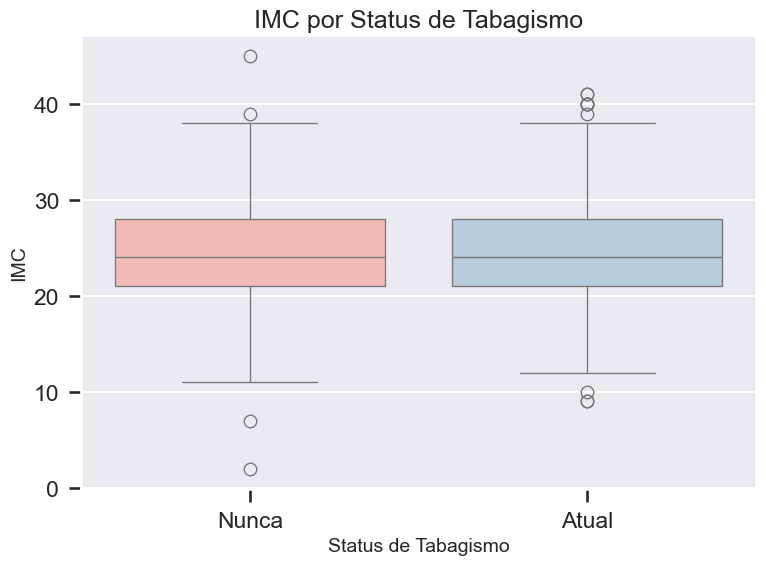

In [8]:
# 4. Boxplot – IMC por Status de Tabagismo
plt.figure(figsize=(8, 6))
sns.boxplot(x='Status_Tabagismo', y='IMC', data=df, palette='Pastel1')
plt.title('IMC por Status de Tabagismo')
plt.xlabel('Status de Tabagismo')
plt.ylabel('IMC')
plt.tight_layout()
plt.show()

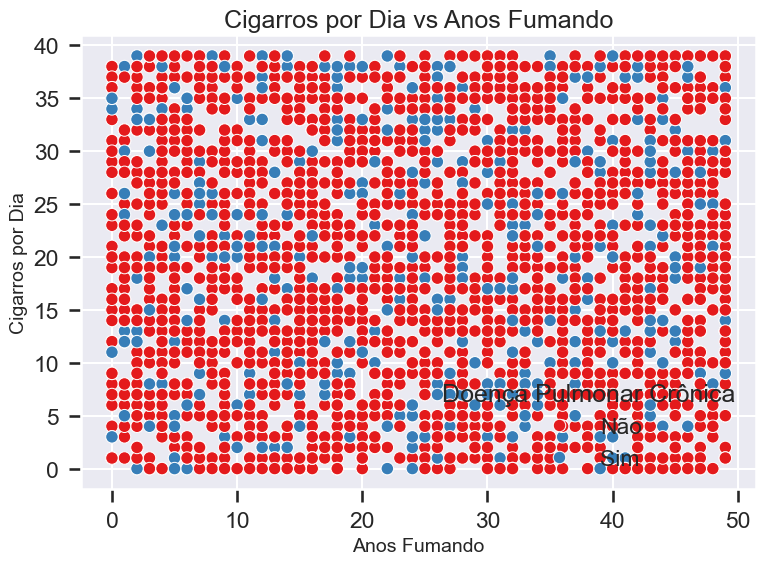

In [9]:
# 5. Scatter Plot – Cigarros por Dia vs Anos Fumando
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Anos_Fumando', y='Cigarros_por_Dia', hue='Doença_Pulmonar_Crônica', data=df, palette='Set1')
plt.title('Cigarros por Dia vs Anos Fumando')
plt.xlabel('Anos Fumando')
plt.ylabel('Cigarros por Dia')
plt.legend(title='Doença Pulmonar Crônica')
plt.tight_layout()
plt.show()